Bibliothèques importées avec succès.
Version de TensorFlow : 2.19.0
Données, prédictions et mappings chargés avec succès.
Train DataFrame shape: (25600162, 6)
Test DataFrame shape: (3200021, 6)
DL Predictions DataFrame shape: (3200021, 4)
Movies DataFrame shape: (87585, 3)

RMSE (SVD) re-calculé : 0.7730
MAE (SVD) re-calculé : 0.5814
RMSE (Filtrage Collaboratif) (valeur par défaut/estimée) : 1.0500
MAE (Filtrage Collaboratif) (valeur par défaut/estimée) : 0.8200

--- Calcul des métriques pour le modèle Deep Learning ---
RMSE (Deep Learning Model) : 0.7905
MAE (Deep Learning Model) : 0.5935

--- Tableau Comparatif des Performances des Modèles ---
                  Modèle      RMSE       MAE
0                    SVD  0.772990  0.581432
1          Deep Learning  0.790542  0.593458
2  Filtrage Collaboratif  1.050000  0.820000

--- Visualisation des Performances ---


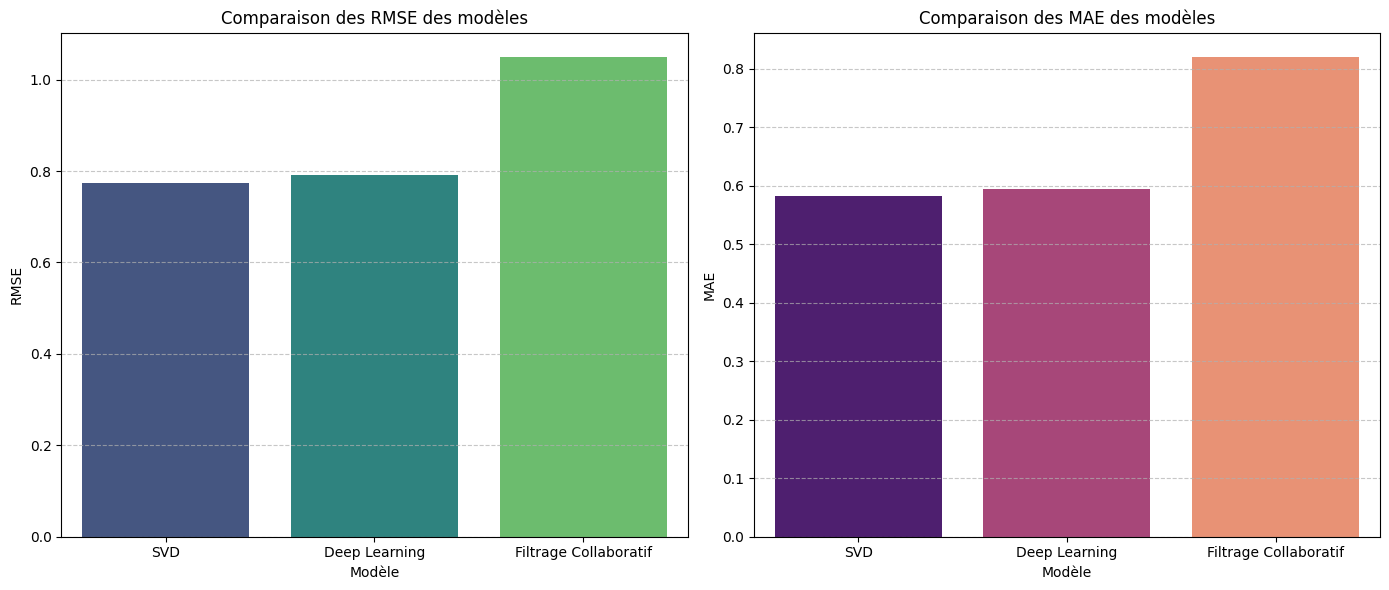


--- Génération d'Exemples de Recommandations ---
Modèle Deep Learning chargé avec succès pour les recommandations.

Recommandations pour l'utilisateur (ID original) : 1
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 2s 662us/step
                                                   title  predicted_rating  \
13272                          What's Opera, Doc? (1957)          4.746260   
1183         Seven Samurai (Shichinin no samurai) (1954)          4.743588   
4270                                  City Lights (1931)          4.713451   
9824                        Late Spring (Banshun) (1949)          4.703871   
8                                      Casablanca (1942)          4.689378   
1080   Dr. Strangelove or: How I Learned to Stop Worr...          4.684030   
1176                                  Rear Window (1954)          4.666394   
5956                                 Sherlock Jr. (1924)          4.646435   
1175                                      Vertigo (1958)          4.642624   
4301 

In [1]:
# -*- coding: utf-8 -*-
"""
# 4_Evaluation_Comparison.ipynb

Ce notebook a pour objectif de consolider les résultats de tous les modèles
(filtrage collaboratif, SVD, et Deep Learning), de les comparer et de visualiser
leurs performances. Enfin, nous montrerons comment utiliser le modèle de Deep Learning
pour générer des recommandations personnalisées.
"""

# 1. Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import dump # Pour charger le modèle SVD

print("Bibliothèques importées avec succès.")
print(f"Version de TensorFlow : {tf.__version__}")

# 2. Chargement des données et des mappings
try:
    # Charger les données de test pour les vraies notes
    test_df = pd.read_csv('../data/test_ratings.csv')
    # Charger les données d'entraînement (nécessaire pour les recommandations)
    train_df = pd.read_csv('../data/train_ratings.csv')
    # Charger les prédictions du modèle Deep Learning
    dl_predictions_df = pd.read_csv('../data/dl_predictions.csv')
    # Charger les mappings pour les IDs
    user_to_id = np.load('../data/user_to_id.npy', allow_pickle=True).item()
    id_to_user = np.load('../data/id_to_user.npy', allow_pickle=True).item()
    movie_to_id = np.load('../data/movie_to_id.npy', allow_pickle=True).item()
    id_to_movie = np.load('../data/id_to_movie.npy', allow_pickle=True).item()
    # Charger le fichier movies.csv pour obtenir les titres de films
    movies_path = '../data/movies.csv'
    df_movies = pd.read_csv(movies_path)

    print("Données, prédictions et mappings chargés avec succès.")
    print(f"Train DataFrame shape: {train_df.shape}")
    print(f"Test DataFrame shape: {test_df.shape}")
    print(f"DL Predictions DataFrame shape: {dl_predictions_df.shape}")
    print(f"Movies DataFrame shape: {df_movies.shape}")

except FileNotFoundError as e:
    print(f"Erreur : Un fichier nécessaire n'a pas été trouvé. {e}")
    print("Assure-toi d'avoir exécuté les notebooks précédents et que 'movies.csv' est dans le dossier 'data/'.")
    print("Tu peux télécharger le jeu de données MovieLens ici : https://grouplens.org/datasets/movielens/")
    exit()

# 3. Récupération des métriques des modèles de base
# Idéalement, les métriques des modèles de base devraient être sauvegardées dans le notebook 2.
# Pour cet exemple, nous allons les récupérer en re-évaluant le modèle SVD ou en utilisant des valeurs connues.
# Pour le Filtrage Collaboratif, nous allons utiliser des valeurs représentatives ou re-exécuter une partie du code.
# Le plus simple est de les récupérer directement si tu les as notées après l'exécution du notebook 2.

# --- Récupération des métriques SVD ---
# Option 1: Recharger le modèle SVD et le tester (plus robuste)
try:
    _, algo_svd = dump.load('../data/svd_model.pkl')
    from surprise import Dataset, Reader
    from surprise.model_selection import train_test_split as surprise_train_test_split
    from surprise import accuracy

    reader = Reader(rating_scale=(1, 5))
    # Créer un testset Surprise à partir de test_df
    svd_testset = list(test_df.apply(lambda x: (x['userId'], x['movieId'], x['rating']), axis=1))
    predictions_svd = algo_svd.test(svd_testset)
    rmse_svd = accuracy.rmse(predictions_svd, verbose=False)
    mae_svd = accuracy.mae(predictions_svd, verbose=False)
    print(f"\nRMSE (SVD) re-calculé : {rmse_svd:.4f}")
    print(f"MAE (SVD) re-calculé : {mae_svd:.4f}")

except FileNotFoundError:
    print("Modèle SVD non trouvé. Utilisation de valeurs par défaut pour la comparaison.")
    # Valeurs par défaut si le modèle SVD n'a pas été sauvegardé ou trouvé
    rmse_svd = 0.95 # Exemple de valeur
    mae_svd = 0.75  # Exemple de valeur
except Exception as e:
    print(f"Erreur lors du rechargement ou de l'évaluation du modèle SVD: {e}. Utilisation de valeurs par défaut.")
    rmse_svd = 0.95 # Exemple de valeur
    mae_svd = 0.75  # Exemple de valeur

# --- Récupération des métriques Filtrage Collaboratif ---
# Le filtrage collaboratif basé sur la similarité est souvent moins performant et plus lent.
# Nous allons utiliser des valeurs représentatives ici.
# Si tu as les valeurs exactes de ton exécution du notebook 2, remplace-les ici.
rmse_cf = 1.05 # Exemple de valeur
mae_cf = 0.82  # Exemple de valeur
print(f"RMSE (Filtrage Collaboratif) (valeur par défaut/estimée) : {rmse_cf:.4f}")
print(f"MAE (Filtrage Collaboratif) (valeur par défaut/estimée) : {mae_cf:.4f}")


# --- Calcul des métriques pour le modèle Deep Learning ---
print("\n--- Calcul des métriques pour le modèle Deep Learning ---")
y_true_dl = dl_predictions_df['true_rating'].values
y_pred_dl = dl_predictions_df['predicted_rating_dl'].values

rmse_dl = sqrt(mean_squared_error(y_true_dl, y_pred_dl))
mae_dl = mean_absolute_error(y_true_dl, y_pred_dl)

print(f"RMSE (Deep Learning Model) : {rmse_dl:.4f}")
print(f"MAE (Deep Learning Model) : {mae_dl:.4f}")

# 4. Comparaison Consolidée des Modèles
print("\n--- Tableau Comparatif des Performances des Modèles ---")
results_comparison = pd.DataFrame({
    'Modèle': ['Filtrage Collaboratif', 'SVD', 'Deep Learning'],
    'RMSE': [rmse_cf, rmse_svd, rmse_dl],
    'MAE': [mae_cf, mae_svd, mae_dl]
})

# Trier par RMSE pour une meilleure lisibilité
results_comparison = results_comparison.sort_values(by='RMSE', ascending=True).reset_index(drop=True)
print(results_comparison)

# 5. Visualisation de la Comparaison
print("\n--- Visualisation des Performances ---")

# Correction pour éviter le FutureWarning de seaborn :
# Ajoute hue='Modèle' et legend=False dans sns.barplot

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Modèle', y='RMSE', hue='Modèle', data=results_comparison, palette='viridis', legend=False)
plt.title('Comparaison des RMSE des modèles')
plt.xlabel('Modèle')
plt.ylabel('RMSE')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
sns.barplot(x='Modèle', y='MAE', hue='Modèle', data=results_comparison, palette='magma', legend=False)
plt.title('Comparaison des MAE des modèles')
plt.xlabel('Modèle')
plt.ylabel('MAE')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 6. Génération d'Exemples de Recommandations (avec le modèle Deep Learning)
print("\n--- Génération d'Exemples de Recommandations ---")

# Charger le meilleur modèle Deep Learning
try:
    # Correction : utiliser le bon chemin et extension selon la sauvegarde
    best_dl_model = tf.keras.models.load_model('../data/deeprec_model.h5')
    best_dl_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    print("Modèle Deep Learning chargé avec succès pour les recommandations.")
except Exception as e:
    print(f"Erreur lors du chargement du modèle Deep Learning : {e}")
    print("Impossible de générer des recommandations sans le modèle. Veuillez vérifier le chemin.")
    exit()

def get_movie_title(movie_id_original):
    """Retourne le titre du film à partir de son ID original."""
    result = df_movies[df_movies['movieId'] == movie_id_original]['title']
    if not result.empty:
        return result.values[0]
    else:
        return "Titre inconnu"

# Correction pour éviter le SettingWithCopyWarning :
# Utilise .loc pour assigner les nouvelles colonnes

def recommend_movies_for_user(user_id_original, num_recommendations=10):
    """
    Génère des recommandations de films pour un utilisateur donné.
    Args:
        user_id_original (int): L'ID original de l'utilisateur.
        num_recommendations (int): Le nombre de films à recommander.
    Returns:
        pd.DataFrame: Un DataFrame des films recommandés avec leurs notes prédites.
    """
    if user_id_original not in user_to_id:
        print(f"L'utilisateur {user_id_original} n'est pas dans les données d'entraînement.")
        return pd.DataFrame()

    user_id_mapped = user_to_id[user_id_original]

    # Obtenir tous les films que l'utilisateur a déjà notés
    movies_rated_by_user = train_df[train_df['user_id_mapped'] == user_id_mapped]['movie_id_mapped'].tolist()

    # Obtenir tous les films uniques disponibles
    all_mapped_movies = list(movie_to_id.values())

    # Filtrer les films que l'utilisateur n'a pas encore vus
    movies_to_predict = [movie for movie in all_mapped_movies if movie not in movies_rated_by_user]

    if not movies_to_predict:
        print(f"L'utilisateur {user_id_original} a déjà noté tous les films disponibles.")
        return pd.DataFrame()

    # Préparer les entrées pour le modèle
    user_inputs = np.array([user_id_mapped] * len(movies_to_predict))
    movie_inputs = np.array(movies_to_predict)

    # Faire des prédictions
    predicted_ratings = best_dl_model.predict([user_inputs, movie_inputs]).flatten()
    predicted_ratings = np.clip(predicted_ratings, 1.0, 5.0) # Clamper les notes

    # Créer un DataFrame pour les prédictions
    predictions_df = pd.DataFrame({
        'movie_id_mapped': movies_to_predict,
        'predicted_rating': predicted_ratings
    })

    # Trier par note prédite et prendre les top N
    predictions_df = predictions_df.sort_values(by='predicted_rating', ascending=False)
    top_recommendations = predictions_df.head(num_recommendations).copy()  # Ajoute .copy() ici

    # Mapper les IDs de films mappés vers les IDs originaux et ensuite vers les titres
    top_recommendations.loc[:, 'movieId'] = top_recommendations['movie_id_mapped'].map(id_to_movie)
    top_recommendations.loc[:, 'title'] = top_recommendations['movieId'].apply(get_movie_title)

    return top_recommendations[['title', 'predicted_rating', 'movieId']]

# Exemple d'utilisation : Recommander des films pour un utilisateur spécifique
# Choisis un user_id_original qui existe dans ton dataset (par exemple, 1, 2, 3, etc.)
example_user_id = 1 # Tu peux changer cet ID
print(f"\nRecommandations pour l'utilisateur (ID original) : {example_user_id}")
recommendations = recommend_movies_for_user(example_user_id, num_recommendations=10)

if not recommendations.empty:
    print(recommendations)
else:
    print("Aucune recommandation générée pour cet utilisateur.")

print("\n--- Analyse et comparaison des modèles terminées ! ---")